In [5]:
from __future__ import print_function, division
from builtins import range, input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 50
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/PROJECT_DATA/COVID'
normal_path = '/content/drive/MyDrive/PROJECT_DATA/NON COVID'
pneumonia_path = '/content/drive/MyDrive/PROJECT_DATA/PNEUMONIA '
# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*') 
normal_files = glob(normal_path + '/*')
pneumonia_files = glob(pneumonia_path + '/*')

In [4]:
# Preparing Labels
covid_labels = []
normal_labels = []
pneumonia_labels = []

covid_images=[]
normal_images=[]
pneumonia_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('COVID')
for i in range(len(normal_files)):
  image = cv2.imread(normal_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  normal_images.append(image)
  normal_labels.append('Normal')
for i in range(len(pneumonia_files)):
  image = cv2.imread(pneumonia_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  pneumonia_images.append(image)
  pneumonia_labels.append('Pneumonia')

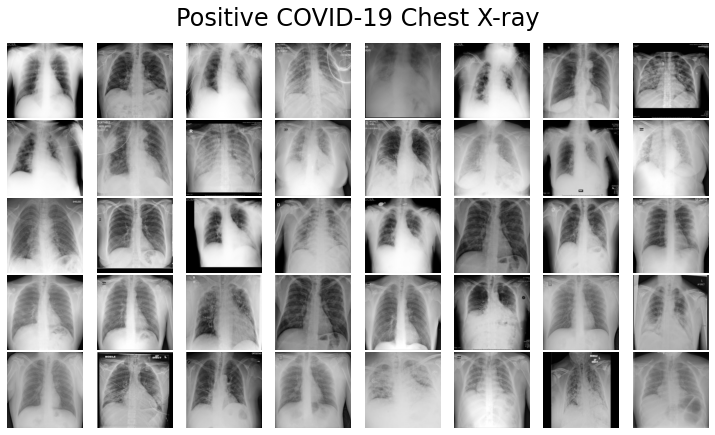

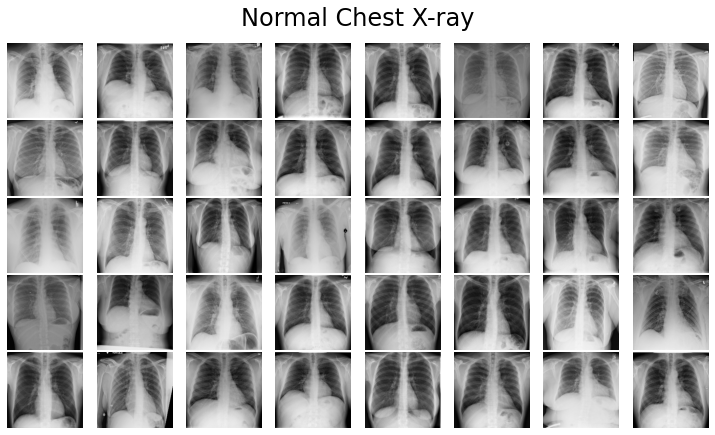

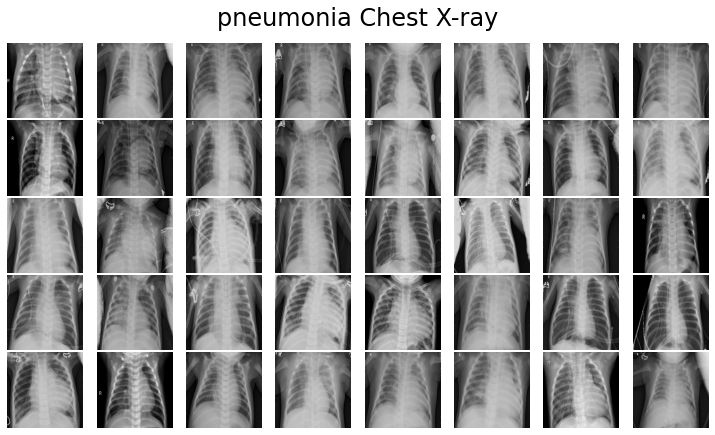

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(normal_images, 'Normal Chest X-ray')
plot_images(pneumonia_images, 'pneumonia Chest X-ray')

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
normal_images = np.array(normal_images) / 255
pneumonia_images = np.array(pneumonia_images) / 255

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
normal_x_train, normal_x_test, normal_y_train, normal_y_test = train_test_split(
    normal_images, normal_labels, test_size=0.2)
pneumonia_x_train, pneumonia_x_test, pneumonia_y_train, pneumonia_y_test = train_test_split(
    pneumonia_images, pneumonia_labels, test_size=0.2)


X_train = np.concatenate((normal_x_train, covid_x_train,pneumonia_x_train), axis=0)
X_test = np.concatenate((normal_x_test, covid_x_test,pneumonia_x_test), axis=0)
y_train = np.concatenate((normal_y_train, covid_y_train,pneumonia_y_train), axis=0)
y_test = np.concatenate((normal_y_test, covid_y_test,pneumonia_y_test), axis=0)


In [ ]:
import numpy as np
import pandas as pd
np.unique(y_train)

array(['COVID', 'Normal', 'Pneumonia'], dtype='<U9')

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_train=label_encoder.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test=label_encoder.fit_transform(y_test)
y_test = to_categorical(y_test)

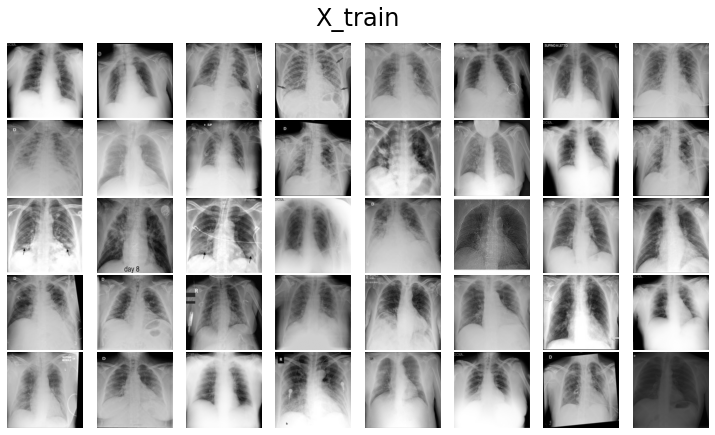

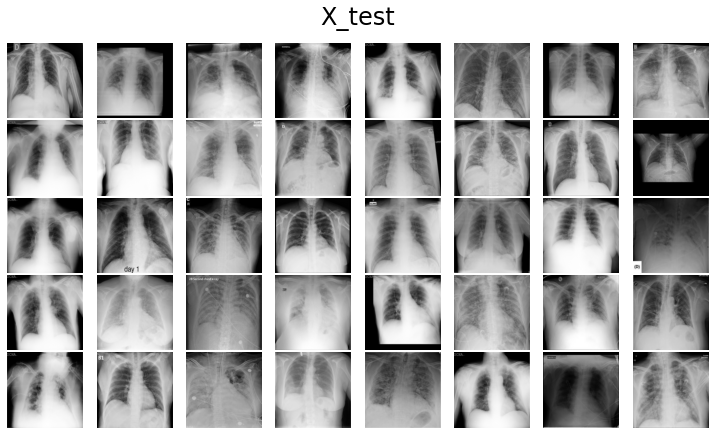

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_test, y_test),
                    validation_steps=10,
                    steps_per_epoch=30,epochs=30
                    )

Epoch 1/30
30/30 [==============================] - 30s 686ms/step - loss: 1.0384 - accuracy: 0.6552 - val_loss: 0.4347 - val_accuracy: 0.8568
Epoch 2/30
30/30 [==============================] - 19s 627ms/step - loss: 0.5249 - accuracy: 0.8028 - val_loss: 0.3505 - val_accuracy: 0.8632
Epoch 3/30
30/30 [==============================] - 19s 621ms/step - loss: 0.3849 - accuracy: 0.8440 - val_loss: 0.2607 - val_accuracy: 0.8989
Epoch 4/30
30/30 [==============================] - 19s 622ms/step - loss: 0.3681 - accuracy: 0.8566 - val_loss: 0.3172 - val_accuracy: 0.8611
Epoch 5/30
30/30 [==============================] - 19s 622ms/step - loss: 0.3463 - accuracy: 0.8556 - val_loss: 0.2303 - val_accuracy: 0.9179
Epoch 6/30
30/30 [==============================] - 19s 623ms/step - loss: 0.3068 - accuracy: 0.8851 - val_loss: 0.2350 - val_accuracy: 0.9116
Epoch 7/30
30/30 [==============================] - 19s 621ms/step - loss: 0.3132 - accuracy: 0.8761 - val_loss: 0.2391 - val_accuracy: 0.9011

In [ ]:
model.save('vgg_chest.h5')

In [ ]:
model.save_weights('vggweights_chest.hdf5')

In [ ]:
model = load_model('/content/vgg_chest.h5')

In [ ]:
score=model.evaluate(X_test,y_test)
print("Accuracy: %.2f%%" % (score[1]*100))

15/15 [==============================] - 2s 63ms/step - loss: 0.1344 - accuracy: 0.9326
Accuracy: 93.26%


In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

15/15 [==============================] - 1s 28ms/step


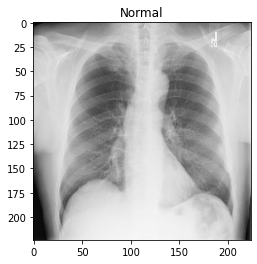

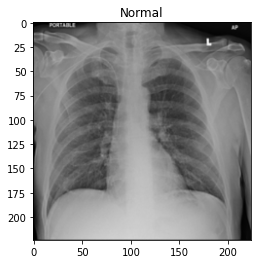

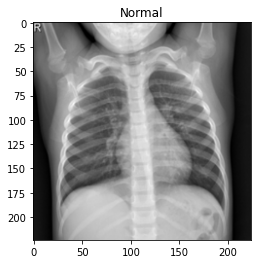

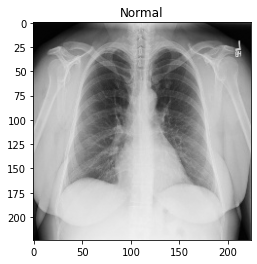

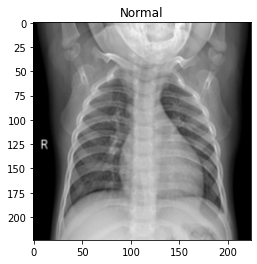

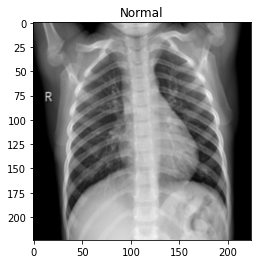

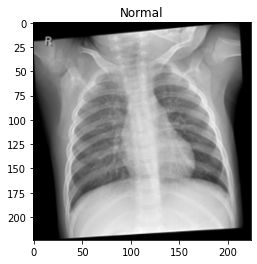

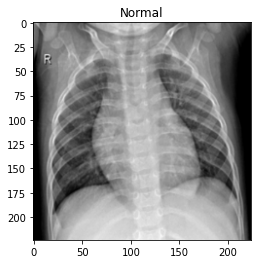

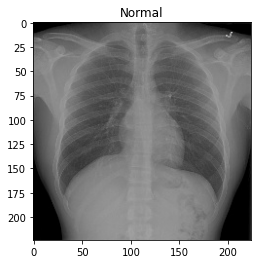

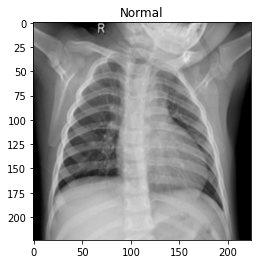

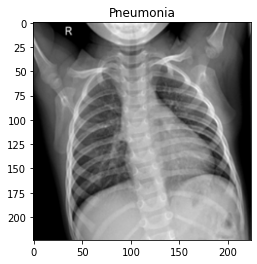

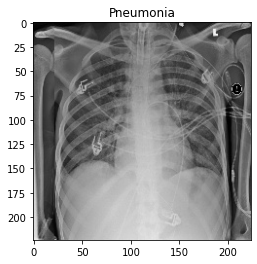

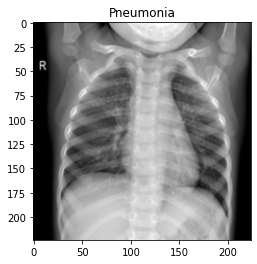

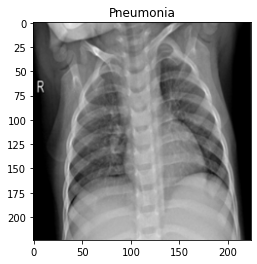

In [ ]:
prediction=np.concatenate((y_pred[:5],y_pred[200:205],y_pred[-5:-1]),axis=0)
for index, probability in enumerate(prediction):
  if (probability[0] > probability[1]) and (probability[0] > probability[2]):
    plt.title('Covid')
  elif (probability[1] > probability[0]) and (probability[1] > probability[2]):
    plt.title('Normal')
  else:
    plt.title("Pneumonia")
  plt.imshow(X_test[index])
  plt.show()
# Here argmax() function can also be used

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Confusion Matrix


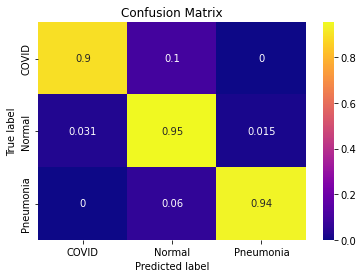

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','Normal','Pneumonia']
  tick_marks = [0.5,1.5,2.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin,target_names=['covid','Normal','Pneumonia']))

              precision    recall  f1-score   support

       covid       0.95      0.90      0.92       164
      Normal       0.93      0.95      0.94       261
   Pneumonia       0.92      0.94      0.93        50

    accuracy                           0.93       475
   macro avg       0.93      0.93      0.93       475
weighted avg       0.93      0.93      0.93       475



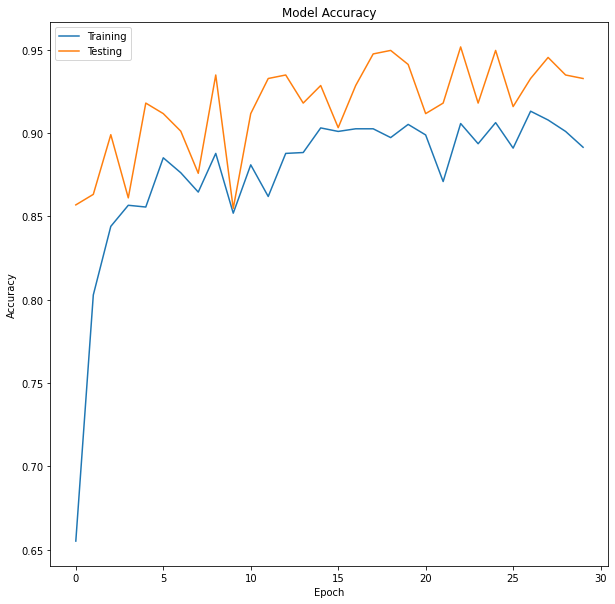

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

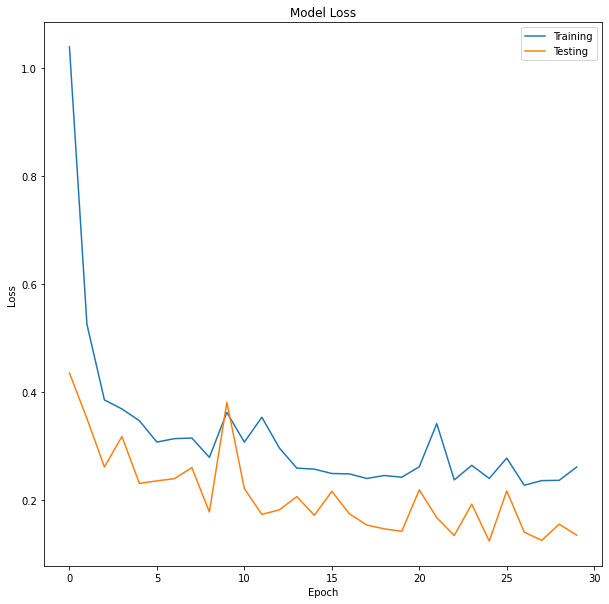

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()